## Sobol’ Variance-Based Sensitivity Analysis

### Historical Background

Variance-based sensitivity analysis was formalized by **Ilya M. Sobol’**, a Russian mathematician, in **1990**.  
Sobol’ was working on uncertainty propagation in complex computational models, where small changes in inputs could lead to large, nonlinear changes in outputs.  

His key insight was that **a model’s output variance can be decomposed into contributions from each input variable and their interactions**.

This approach built upon earlier ideas in **ANOVA (Analysis of Variance)** and **factorial design**, but extended them to arbitrary nonlinear, non-additive models.  
Sobol’s work provided a rigorous, model-independent way to measure how much of the uncertainty in the model output can be attributed to uncertainty in each input.

Today, the **Sobol’ method** (often misspelled “Sobel”) is a cornerstone of **global sensitivity analysis (GSA)** — used across hydrology, climatology, ecology, and environmental modeling.

---

### Conceptual Overview

Consider a model:

$$
Y = f(X_1, X_2, \ldots, X_k)
$$

where each $X_i$ is an uncertain input variable with a known probability distribution,  
and $Y$ is the scalar model output (e.g., recharge rate, runoff, or suitability index).

The **total output variance** can be decomposed as:

$$
Var(Y) = \sum_i V_i + \sum_{i<j} V_{ij} + \sum_{i<j<k} V_{ijk} + \cdots + V_{1,2,\ldots,k}
$$

**where:**

- $V_i = Var_{X_i}\big(E[Y|X_i]\big)$ — the portion of output variance explained by input \(X_i\) alone (main effect),  

- $V_{ij} = Var_{X_{i},X_{j}}\big(E[Y|X_i, X_j]\big) - V_i - V_j$ — the variance explained by the *interaction* of $X_i$ and $X_j$,

- and so on.

Each of these terms represents how much of the output variance comes from each combination of inputs.

---

### Sobol’ Sensitivity Indices

Sobol’ defined **dimensionless indices** that normalize these variance components:

- **First-order (main effect) index:**
  $$
  S_i = \frac{V_i}{Var(Y)}
  $$

  This measures the direct contribution of input $X_i$ to the output variance.

- **Second-order (interaction) index:**

$$
  S_{ij} = \frac{V_{ij}}{Var(Y)}
$$

  This measures the contribution of the interaction between \(X_i\) and \(X_j\).

- **Total-order index:**
  $$
  S_{T_i} = 1 - \frac{Var_{X_{\sim i}}\big(E[Y|X_{\sim i}]\big)}{Var(Y)}
  $$
  
  or equivalently:
  $$
  S_{T_i} = S_i + \sum_{j \ne i} S_{ij} + \sum_{j \ne i, k \ne i,j} S_{ijk} + \cdots
  $$

  This measures **all** effects involving $X_i$, including its interactions.

In short:

- $S_i$ → how important a variable is *on its own*  
- $S_{T_i}$ → how important a variable is *in total* (including interactions)

The sum of all first-order indices equals 1 only for purely additive models; otherwise, the difference $1 - \sum_i S_i$ quantifies total interaction strength.

---

### Why Sobol’ Analysis Matters in Ecohydrology

In ecohydrological models, relationships are rarely linear — infiltration, evapotranspiration, and recharge often depend multiplicatively on multiple factors (soil, vegetation, slope, climate).  
Sobol’ analysis helps to:

- **Rank inputs** by how much they drive uncertainty in outputs.  
- **Detect interactions** (e.g., rainfall × soil permeability).  
- **Assess model structure** — whether the model is dominated by a few key variables or by complex nonlinear couplings.  
- **Guide data collection** — focus effort on the variables with high Sobol’ indices.

For example, in a groundwater recharge model, you might find that precipitation variability explains 60% of the variance in predicted recharge, but its total index is 0.9 — meaning interactions (with soil or vegetation) amplify its role.

---

### Relationship to Morris

| Feature   | Morris Method                                 | Sobol’ Method |
|:----------|:----------------------------------------------|:--------------|
| Type      | Qualitative / Screening                       | Quantitative / Global |
| Metric    | Mean $\mu^*$ and std $\sigma$ of elementary effects  |Variance decomposition |
| Sampling  | Trajectory-based (few hundred runs)           |Monte Carlo or quasi–Monte Carlo (thousands of runs) |
| Output    | Relative importance, nonlinearity indication  | Fraction of total variance explained |
| Strength  | Low-cost first-pass screening                 | Precise quantification of global sensitivity |

Sobol’ is typically applied **after** Morris identifies which inputs merit deeper investigation.

---

### Next Steps

In the next sections, we will:

1. Build intuition using simple synthetic functions (e.g., the Ishigami function). 

2. Compute Sobol’ indices from first principles (step-by-step variance decomposition).  

3. Compare results with `SALib` implementations for verification.  

4. Visualize the indices and interpret them in the context of ecohydrological or spatial decision models.


## Step 1: The Ishigami Function — Building Intuition

The **Ishigami function** is a well-known test case in sensitivity analysis because it includes both strong **nonlinear** effects and **interactions** between variables.  


**It is defined as:**

$$
f(x_1, x_2, x_3) = \sin(x_1) + a \sin^2(x_2) + b x_3^4 \sin(x_1)
$$

Typical parameter values are $a = 7$ and $b = 0.1$.  
Each $x_i$ is drawn uniformly from $[-π, π]$.

### Key properties

- $x_1$ affects $Y$ nonlinearly through $\sin(x_1)$.
- $x_2$ affects $Y$ only through $\sin^2(x_2)$.
- $x_3$ interacts **only** with $x_1$ (via $b x_3^4 \sin(x_1)$).
- Thus, $x_3$ has **no main effect** but a **strong interaction effect**.

The known analytical Sobol’ indices (for $a = 7, b = 0.1$) are:

| Parameter | $S_i$ (First-order) | $S_{T_i}$ (Total-order) |
|:-----------|:----------------------|:---------------------------|
| $x_1$    | 0.314                | 0.558                     |
| $x_2$    | 0.442                | 0.442                     |
| $x_3$    | 0.000                | 0.244                     |

You can see that:
- $x_2$ drives much of the output variance directly.
- $x_3$ matters **only** through its interaction with $x_1$.
- The gap between $S_i$ and $S_{T_i}$ indicates **interaction strength**.


In [1]:
# Step 1: Define and explore the Ishigami function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define Ishigami function
def ishigami(x1, x2, x3, a=7, b=0.1):
    return np.sin(x1) + a * np.sin(x2)**2 + b * x3**4 * np.sin(x1)

# Sample inputs
N = 5000
x1 = np.random.uniform(-np.pi, np.pi, N)
x2 = np.random.uniform(-np.pi, np.pi, N)
x3 = np.random.uniform(-np.pi, np.pi, N)

# Compute model output
y = ishigami(x1, x2, x3)

# Quick summary
pd.DataFrame({
    "mean": [y.mean()],
    "variance": [y.var()],
    "min": [y.min()],
    "max": [y.max()]
})


,mean,variance,min,max
0,3.432564,13.580454,-10.022532,17.060055


## Step 1.1: Visualizing the Ishigami Function

The Ishigami function lives in a three-dimensional input space ($x_1, x_2, x_3 \in [-\pi, \pi]$),  
so we often visualize it using 2D slices.

Below, we:
- Fix $x_3 = 0$ to examine the main nonlinear contributions from $x_1$ and $x_2$.
- Then show 1D cross-sections for each variable to highlight how $f(x)$ responds when others are fixed.

These visualizations help reveal:
- Strong nonlinearity in $x_1$ and $x_2$,
- Interactions introduced by $x_3$.


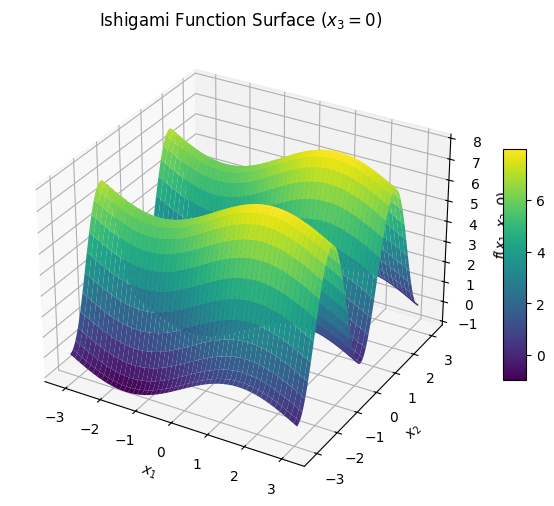

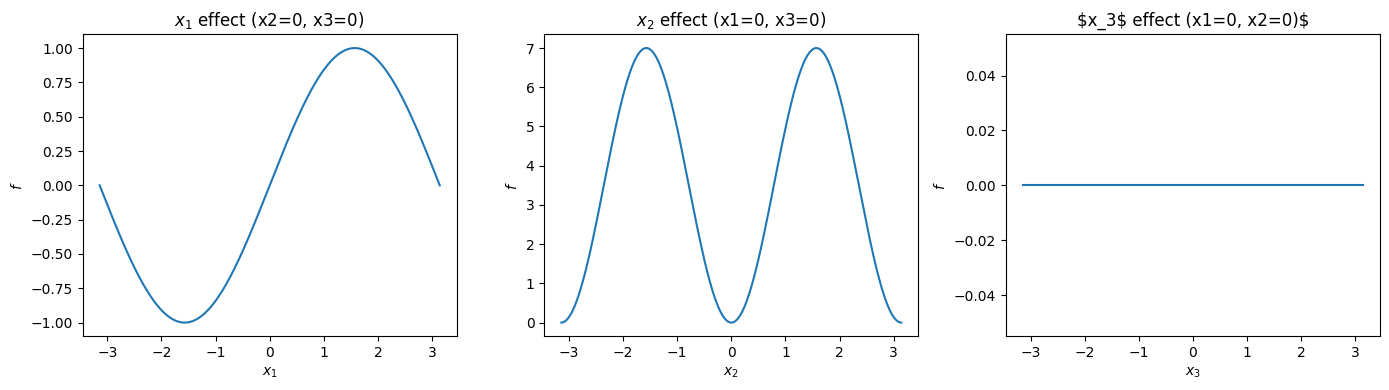

In [2]:
# Step 1.1: Visualize the Ishigami function

from mpl_toolkits.mplot3d import Axes3D

# Define ranges for x1 and x2
n = 200
x1_vals = np.linspace(-np.pi, np.pi, n)
x2_vals = np.linspace(-np.pi, np.pi, n)
X1, X2 = np.meshgrid(x1_vals, x2_vals)

# Fix x3 = 0
Y = ishigami(X1, X2, 0)

# --- 3D surface plot ---
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X1, X2, Y, cmap="viridis", linewidth=0, antialiased=True)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x_1, x_2, 0)$")
ax.set_title("Ishigami Function Surface ($x_3 = 0$)")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()

# --- 1D slices for intuition ---
x = np.linspace(-np.pi, np.pi, 400)
fig, ax = plt.subplots(1, 3, figsize=(14,4))

ax[0].plot(x, ishigami(x, 0, 0))
ax[0].set_title("$x_1$ effect (x2=0, x3=0)")
ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$f$")

ax[1].plot(x, ishigami(0, x, 0))
ax[1].set_title("$x_2$ effect (x1=0, x3=0)")
ax[1].set_xlabel("$x_2$")
ax[1].set_ylabel("$f$")

ax[2].plot(x, ishigami(0, 0, x))
ax[2].set_title("$x_3$ effect (x1=0, x2=0)$")
ax[2].set_xlabel("$x_3$")
ax[2].set_ylabel("$f$")

plt.tight_layout()
plt.show()


## Step 2: Estimating Sobol’ Indices from Monte Carlo Samples

Sobol’ sensitivity analysis is based on decomposing the variance of the model output

$$
Y = f(X_1, X_2, \ldots, X_k)
$$

into contributions from each input and their interactions.

We will estimate:
- the **first-order index** $S_i$, which measures how much of the output variance can be explained by input $X_i$ alone;
- and the **total-order index** $S_{T_i}$, which measures how much of the output variance is associated with $X_i$, including all its interactions.

We will do this using Monte Carlo sampling and a standard Sobol’ estimator based on two sample matrices.

### Core idea

1. Draw two independent random matrices $A$ and $B$, each of shape $(N, k)$.  
   Each row is one random draw of all inputs.

2. For each input $X_i$, build a hybrid matrix $A_B^{(i)}$ by:
   - taking all columns from $A$ except column $i$, which we take from $B$.

   So $A_B^{(i)}$ is “mostly A, but with $X_i$ from $B$.”

3. Evaluate the model $f$ on:
   - all rows of $A$  → call that $f(A)$
   - all rows of $B$  → call that $f(B)$
   - all rows of each $A_B^{(i)}$ → call that $f(A_B^{(i)})$

From these evaluations, we can estimate:

- Total output variance:

$$
  V = Var(Y) \approx Var\big(f(A)\big)
$$

- First-order Sobol’ index for input \(X_i\):

$$
  S_i \approx
  \frac{
    \frac{1}{N} \sum_{n=1}^N f(B)_n \, f(A_B^{(i)})_n \;-\;
    \left(\frac{1}{N} \sum_{n=1}^N f(A)_n \right)^2
  }{
    Var(f(A))
  }
 $$

  Intuition: this measures how much knowing \(X_i\) alone reduces uncertainty in the output.

- Total-order Sobol’ index for input \(X_i\):

$$
  S_{T_i} \approx
  \frac{
    \frac{1}{N} \sum_{n=1}^N
      \left( f(A)_n - f(A_B^{(i)})_n \right)^2
    \bigg/ 2
  }{
    Var(f(A))
  }
  $$

  Intuition: this measures how much the output would vary if we were to randomize $X_i$ while holding all other inputs fixed. High $S_{T_i}$ means $X_i$ matters either directly or through interactions.

In this step, we will:

- generate A and B,
- build the hybrid matrices,
- compute $S_i$ and $S_{T_i}$ for the Ishigami function.


In [3]:
import numpy as np
import pandas as pd

# We'll reuse ishigami() from earlier

def ishigami(x1, x2, x3, a=7, b=0.1):
    return np.sin(x1) + a * np.sin(x2)**2 + b * x3**4 * np.sin(x1)

# 1. sampling setup
def sample_inputs(N):
    # each Xi ~ Uniform[-pi, pi]
    return np.random.uniform(-np.pi, np.pi, size=(N, 3))

# 2. helper to evaluate f row-wise
def eval_model(X):
    # X is shape (N,3) with columns [x1, x2, x3]
    return ishigami(X[:,0], X[:,1], X[:,2])

# 3. build A, B and hybrid matrices A_B^(i)
def sobol_indices_ishigami(N=10000, seed=0):
    rng = np.random.default_rng(seed)

    # Draw two independent input matrices A and B
    A = rng.uniform(-np.pi, np.pi, size=(N, 3))
    B = rng.uniform(-np.pi, np.pi, size=(N, 3))

    # Evaluate model at A and B
    fA = eval_model(A)
    fB = eval_model(B)

    # Variance of the output (denominator for normalization)
    VY = np.var(fA, ddof=1)

    # estimate mean(fA) and mean(fB) - we mostly use mean(fA)
    fA_mean = np.mean(fA)

    S_first = []
    S_total = []

    for i in range(3):  # for each input x1, x2, x3
        # Construct A_B^(i): all columns from A except column i from B
        A_Bi = A.copy()
        A_Bi[:, i] = B[:, i]

        fABi = eval_model(A_Bi)

        # First-order index estimator (Sobol 1993-style / Saltelli 2002 variant)
        # S_i = [ E( f(B) * f(A_Bi) ) - (E f(A))^2 ] / Var(f(A))
        numerator_first = np.mean(fB * fABi) - (fA_mean ** 2)
        S_i = numerator_first / VY

        # Total-order index estimator
        # S_Ti = E[ (f(A) - f(A_Bi))^2 ] / (2 Var(f(A)))
        numerator_total = np.mean((fA - fABi)**2) / 2.0
        S_Ti = numerator_total / VY

        S_first.append(S_i)
        S_total.append(S_Ti)

    # Pack into a DataFrame for readability
    df = pd.DataFrame({
        "S_first": S_first,
        "S_total": S_total
    }, index=["x1", "x2", "x3"])

    return df, VY, fA_mean

sobol_df, varY_est, meanY_est = sobol_indices_ishigami(N=10000, seed=123)
sobol_df, varY_est, meanY_est


(     S_first   S_total
 x1  0.372584  0.565666
 x2  0.479521  0.450329
 x3  0.034654  0.242630,
 np.float64(13.520042661023068),
 np.float64(3.4746897059341726))

## Step 2.1: Interpreting Sobol’ Results

Our Monte Carlo estimates for the Ishigami function are:

| Variable | $S_i$ (First-order) | $S_{T_i}$ (Total-order) |
|:----------|:------------------:|:----------------------:|
| $x_1$     | 0.373 | 0.566 |
| $x_2$     | 0.480 | 0.450 |
| $x_3$     | 0.035 | 0.243 |

Estimated output variance: $V_Y \approx 13.52$  
Estimated output mean: $\bar{Y} \approx 3.47$

### Interpretation

- **$S_i$ (first-order index)** measures how much of the total variance in the model output can be explained by that variable alone, *holding all others constant*.  
- **$S_{T_i}$ (total-order index)** measures how much of the variance is due to that variable, *including its interactions with others*.

From the table:

- $x_1$ shows a **strong direct effect** ($S_1 = 0.37$) and a **moderate interaction** ($S_{T_1} - S_1 \approx 0.19$).  
  → It influences $Y$ both directly and through its interaction with $x_3$.

- $x_2$ has the **largest first-order effect** ($S_2 = 0.48$) and nearly identical total-order value.  
  → This means $x_2$ acts **independently**—it explains much of the variance by itself, with little interaction.

- $x_3$ has a **small first-order effect** but a **large interaction component** ($S_{T_3} - S_3 \approx 0.21$).  
  → It matters primarily *through its interaction* with $x_1$ in the term $b x_3^4 \sin(x_1)$.

### Summary

- The Ishigami function confirms that:
  - $x_2$ is the **dominant independent variable**.  
  - $x_1$ has both main and interactive effects.  
  - $x_3$ is **purely interactive**, affecting $Y$ only through coupling with $x_1$.
- The small differences between analytical and simulated results arise from sampling error in Monte Carlo estimation.

Next, we’ll **visualize these results** using a side-by-side bar plot to clearly compare $S_i$ and $S_{T_i}$ for each variable.


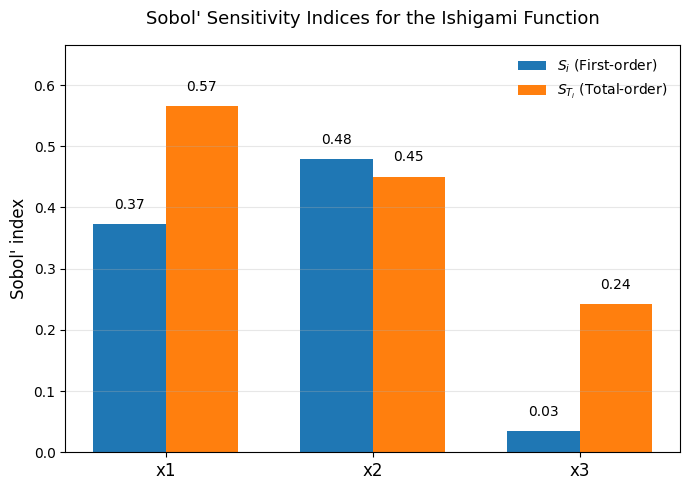

In [4]:
# Step 2.2: Visualizing first-order and total-order Sobol' indices

fig, ax = plt.subplots(figsize=(7,5))

# set bar width and x positions
bar_width = 0.35
x = np.arange(len(sobol_df.index))

# bars for S_first and S_total
ax.bar(x - bar_width/2, sobol_df["S_first"], width=bar_width, label=r"$S_i$ (First-order)", color="#1f77b4")
ax.bar(x + bar_width/2, sobol_df["S_total"], width=bar_width, label=r"$S_{T_i}$ (Total-order)", color="#ff7f0e")

# axis and title formatting
ax.set_xticks(x)
ax.set_xticklabels(sobol_df.index, fontsize=12)
ax.set_ylabel("Sobol' index", fontsize=12)
ax.set_title("Sobol' Sensitivity Indices for the Ishigami Function", fontsize=13, pad=15)
ax.legend(frameon=False)

# Add text labels above bars
for i in range(len(x)):
    ax.text(x[i] - bar_width/2, sobol_df["S_first"].iloc[i] + 0.02, f"{sobol_df['S_first'].iloc[i]:.2f}",
            ha='center', va='bottom', fontsize=10, color='black')
    ax.text(x[i] + bar_width/2, sobol_df["S_total"].iloc[i] + 0.02, f"{sobol_df['S_total'].iloc[i]:.2f}",
            ha='center', va='bottom', fontsize=10, color='black')

ax.set_ylim(0, max(sobol_df["S_total"].max(), sobol_df["S_first"].max()) + 0.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### Step 2.2 Interpretation

In the bar plot below:

- The **blue bars** ($S_i$) represent how much variance each input explains on its own (main effects).
- The **orange bars** ($S_{T_i}$) show how much variance each input contributes including interactions.

From the Ishigami function:

- $x_2$ dominates the variance as an independent factor.
- $x_1$ has a strong main effect but also interacts with $x_3$.
- $x_3$ barely contributes on its own but has a notable interaction effect—this is classic Ishigami behavior.

When $S_{T_i} - S_i$ is large, it signals **non-additivity** or **interaction** in the model’s response surface.

## Step 3: How Monte Carlo Sampling is Used in Sobol’ Sensitivity Analysis

Monte Carlo (MC) sampling is the engine that powers Sobol’s method.  
Sobol’ indices are *variance-based*, which means they quantify **how much of the variance in a model’s output** is due to uncertainty (or variability) in each of its inputs.

But to estimate those variances and covariances, we need *many* realizations of the model.  
That’s where Monte Carlo sampling comes in.

---

### 3.1 What We’re Sampling in General

In the Sobol’ framework, we treat each model input as a **random variable** with a specified distribution.
For a model:

$$
Y = f(X_1, X_2, \ldots, X_k)
$$

we define a joint input distribution:

$$
(X_1, X_2, \ldots, X_k) \sim p(X)
$$

Monte Carlo sampling simply means:
- drawing many random combinations of inputs from  $p(X)$,
- running the model $f$ for each sample,
- and then analyzing how changes in each $X_i$ influence the distribution of $Y$.

From these samples, we can estimate:
- the total output variance $Var(Y)$,
- and how much of that variance is attributable to each input or combination of inputs.

---

### 3.2 What That Means for MCDA

In **multi-criteria decision analysis (MCDA)**, our “model” often looks like this:

$$
S = \sum_{i=1}^{k} w_i \, x_i
$$

where:
- $x_i$ are **normalized criterion layers** (e.g., slope, soil permeability, land cover suitability),
- $w_i$ are **weights** representing the relative importance of each criterion,
- and $S$ is the resulting **suitability score** (often a raster).

So the MCDA suitability map is a deterministic function:

$$
S = f(w_1, w_2, \ldots, w_k)
$$

where the “inputs” are the weights.

---

### 3.3 Using Monte Carlo Sampling for MCDA

In this context, we use Monte Carlo sampling to represent **uncertainty in the weights**.

- Each Monte Carlo sample corresponds to **one possible weighting configuration**.
- Typically, we assume the weights follow a **Dirichlet distribution**, since it ensures they are:
  - non-negative, and
  - sum to 1.

So for each sample $w^{(n)} = [w_1^{(n)}, \ldots, w_k^{(n)}] \sim Dir(\alpha)$,  
we compute a suitability map (or its mean, variance, or other summary), giving us an output $S^{(n)}$.

By repeating this process many times, we build up a Monte Carlo estimate of:

$$
Var(S)
$$

and can compute Sobol’ indices that tell us:
- which criteria (and which combinations of criteria) most affect the variability of the suitability score.

---

### 3.4 In Summary

| Concept | In Classical Sobol’ (e.g., Ishigami) | In GIS/MCDA Context |
|:--------|:------------------------------------|:--------------------|
| Inputs ($X_i$) | Continuous variables (model factors) | Weights or parameters ($w_i$) |
| Sampling | Uniform on defined ranges | Dirichlet (weights sum to 1) or uniform |
| Output ($Y$) | Model result (scalar or array) | Suitability score (map or region mean) |
| Purpose | Quantify how each factor affects variance | Quantify how each criterion weight affects suitability uncertainty |

---

### 3.5 Intuition

- In MCDA, Sobol’ sensitivity analysis tells you **which weights really matter** — and which could vary without changing the results much.
- The **first-order Sobol’ indices** show which single criteria dominate the suitability pattern.
- The **total-order indices** show where there are *interactions* (e.g., when two layers together produce strong or unexpected outcomes).

Thus, the Monte Carlo samples are not “random pixels” — they are **random decision models**, each representing one plausible set of preferences (weight vectors).

---

> In short: in Sobol’ analysis of MCDA, we use Monte Carlo sampling to explore uncertainty in the *decision weights* — typically by drawing thousands of plausible weight combinations from a Dirichlet distribution — and then measure how those differences propagate through to the final suitability results.
